In [149]:
import warnings
import pandas as pd
import numpy as np
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [150]:
df_path = 'C:\imbalance_forecast\data\df_nord_h_project.csv'
df_nord = pd.read_csv(df_path, index_col=0, parse_dates=True)

# Check for duplicate timestamps in the index and remove duplicates
df_nord = df_nord[~df_nord.index.duplicated(keep='first')]
df_nord.tail(20)

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\samueledelia\AppData\Local\Temp\2\ipykernel_2112\541087384.py:1: SyntaxWarning: invalid escape sequence '\i'
  df_path = 'C:\imbalance_forecast\data\df_nord_h_project.csv'


,SBIL_MWH,SBIL_MWH_lag1,SBIL_MWH_lag2,SBIL_MWH_lag3,SBIL_MWH_lag24,MGP_NORD_PURCHASES,MGP_NORD_SALES,FORECAST_TOTAL_LOAD_MW,TOTAL_LOAD_MW,CURVE_VALUE_kWh,POWER_VALUE_kW
ORAINI,,,,,,,,,,,
2024-11-27 04:00:00,369.053,317.147,252.779,145.204,23.814,15101.563,11095.199,14510.0,14268.0,104625.118,418500.22
2024-11-27 05:00:00,433.838,369.053,317.147,252.779,66.943,16050.278,12146.548,15826.0,15747.0,103873.991,415495.66
2024-11-27 06:00:00,386.907,433.838,369.053,317.147,-217.180,19534.325,17167.808,19528.0,19540.0,117144.109,468576.12
2024-11-27 07:00:00,511.406,386.907,433.838,369.053,-347.169,23005.653,19766.781,23435.0,23651.0,134643.562,538573.83
2024-11-27 08:00:00,255.728,511.406,386.907,433.838,-766.554,25013.929,21269.784,26087.0,26059.0,200184.125,800735.71
2024-11-27 09:00:00,57.032,255.728,511.406,386.907,-646.470,25645.206,20526.590,NaN,NaN,239177.426,956708.84
2024-11-27 10:00:00,NaN,NaN,NaN,NaN,NaN,25273.558,19939.032,NaN,NaN,NaN,NaN
2024-11-27 11:00:00,NaN,NaN,NaN,NaN,NaN,24972.353,19473.360,NaN,NaN,NaN,NaN
2024-11-27 12:00:00,NaN,NaN,NaN,NaN,NaN,23612.949,18512.945,NaN,NaN,NaN,NaN


In [151]:
# Define past, future, and present covariates
past_covariates = df_nord[['TOTAL_LOAD_MW', 'FORECAST_TOTAL_LOAD_MW']]

future_covariates = df_nord[['MGP_NORD_PURCHASES', 'MGP_NORD_SALES']]

present_covariates = df_nord[['SBIL_MWH_lag1', 'SBIL_MWH_lag2', 'SBIL_MWH_lag3', 'SBIL_MWH_lag24', 'CURVE_VALUE_kWh', 'POWER_VALUE_kW']]
target = df_nord['SBIL_MWH']

In [152]:
# Now separate the features and target again
X = df_nord.drop(columns=['SBIL_MWH'])
y = df_nord['SBIL_MWH']

# Make sure to drop rows with NaN values that may have resulted from the shift
X = X.dropna()
y = y.loc[X.index]  # Align y with X after dropping NaNs

In [153]:
# Convert to numpy arrays
X_past = X[['TOTAL_LOAD_MW', 'FORECAST_TOTAL_LOAD_MW']].values

X_future = X[['MGP_NORD_PURCHASES', 'MGP_NORD_SALES']].values

X_present = X[['SBIL_MWH_lag1', 'SBIL_MWH_lag2', 'SBIL_MWH_lag3', 'SBIL_MWH_lag24', 'CURVE_VALUE_kWh', 'POWER_VALUE_kW']].values
y = y.values

# Split the data into training and testing sets
X_past_train, X_past_test, X_future_train, X_future_test, X_present_train, X_present_test, y_train, y_test = train_test_split(
    X_past, X_future, X_present, y, test_size=0.15, shuffle=False)

In [154]:
y_test

array([ 8.279500e+01,  1.821470e+02, -7.389200e+01, -1.829160e+02,
        1.497140e+02, -4.791700e+01, -2.397290e+02, -1.764100e+02,
        8.474700e+01,  1.190420e+02,  7.639600e+01, -1.619700e+02,
       -4.691110e+02, -9.029990e+02, -2.937200e+01,  5.986660e+02,
        9.818070e+02,  1.014502e+03,  5.239700e+02,  1.451570e+02,
       -4.510300e+02, -1.217610e+02, -4.444000e+00, -1.341200e+01,
        2.479620e+02,  2.291610e+02,  1.824770e+02,  1.383900e+02,
       -1.259110e+02, -2.618940e+02,  2.142600e+01,  1.194850e+02,
       -8.930200e+01, -1.247370e+02,  1.421090e+02,  6.228800e+01,
        1.886190e+02,  7.419500e+01,  3.642330e+02,  3.186100e+02,
       -5.740000e-01, -4.377900e+01, -3.642090e+02,  1.093100e+02,
        3.531620e+02,  2.161660e+02, -3.051940e+02, -7.706110e+02,
       -5.164340e+02,  1.879430e+02,  3.777730e+02,  1.740850e+02,
        1.496120e+02,  9.870300e+01,  1.034290e+02, -2.408800e+01,
        4.740100e+01,  3.829700e+01,  9.719700e+01,  9.755700e

In [155]:
# Normalize the data
scaler_X_past = StandardScaler()
scaler_X_future = StandardScaler()
scaler_X_present = StandardScaler()
scaler_y = StandardScaler()

# Reshape for normalization (past covariates)
X_past_train = scaler_X_past.fit_transform(X_past_train)
X_past_test = scaler_X_past.transform(X_past_test)

# Normalize future and present covariates directly
X_future_train = scaler_X_future.fit_transform(X_future_train)
X_future_test = scaler_X_future.transform(X_future_test)
X_present_train = scaler_X_present.fit_transform(X_present_train)
X_present_test = scaler_X_present.transform(X_present_test)

# Normalize the target variable
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Combine past, present, and future covariates for the final model input
X_train = np.concatenate([X_past_train, X_future_train, X_present_train], axis=1)
X_test = np.concatenate([X_past_test, X_future_test, X_present_test], axis=1)

In [156]:
# Define the MLP Model
model1 = Sequential()

# Input layer + First hidden layer with L2 regularization
model1.add(Dense(4, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.1)))

# Second hidden layer with L2 regularization
model1.add(Dense(4, activation='relu', kernel_regularizer=l2(0.1)))

# Output layer (single neuron for regression)
model1.add(Dense(1))

# Adam optimizer with initial learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Compile the model
model1.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model1.fit(X_train, y_train, epochs=100, batch_size=512, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100


c:\Users\samueledelia\.conda\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 751ms/step - loss: 1.9486 - mae: 0.7254 - val_loss: 1.9332 - val_mae: 0.6788
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 695ms/step - loss: 1.9917 - mae: 0.7419 - val_loss: 1.9168 - val_mae: 0.6770
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 770ms/step - loss: 1.9617 - mae: 0.7329 - val_loss: 1.9008 - val_mae: 0.6753
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 593ms/step - loss: 1.9223 - mae: 0.7218 - val_loss: 1.8851 - val_mae: 0.6736
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - loss: 1.9107 - mae: 0.7256 - val_loss: 1.8698 - val_mae: 0.6719
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - loss: 1.8639 - mae: 0.7182 - val_loss: 1.8547 - val_mae: 0.6703
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.8657 - mae: 0.7106 - val_loss: 1.8399 - val_mae: 0.6687
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.8611 - mae: 0.7145 - val_loss: 1.8254 - val_mae: 0.6671
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.8138 - mae: 0.7074

In [157]:
# Evaluate the model on test data
y_pred = model1.predict(X_test)

# Inverse transform predictions and true values to get the original scale
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calculate additional metrics
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2 = r2_score(y_test_orig, y_pred_orig)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Mean Absolute Error: 261.2552
Root Mean Squared Error: 344.3860
R-squared: 0.2120


In [158]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

y_pred_binary = np.where(y_pred >= 0, 1, -1)  # Convert predicted values to binary classes

y_test_binary = np.where(y_test >= 0, 1, -1)  # Assuming the threshold is 0 for classifying into +1 or -1

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()

# Calculate Precision, Recall, Accuracy, F1 Score
P = precision_score(y_test_binary, y_pred_binary, pos_label=1)
R = recall_score(y_test_binary, y_pred_binary, pos_label=1)
Acc = accuracy_score(y_test_binary, y_pred_binary)
F1 = f1_score(y_test_binary, y_pred_binary, pos_label=1)

# Print results
print(f'Confusion Matrix:\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
print(f'Precision (P): {P:.4f}')
print(f'Recall (R): {R:.4f}')
print(f'Accuracy (Acc): {Acc:.4f}')
print(f'F1 Score (F1): {F1:.4f}')

Confusion Matrix:
TN: 215, FP: 10, FN: 63, TP: 39
Precision (P): 0.7959
Recall (R): 0.3824
Accuracy (Acc): 0.7768
F1 Score (F1): 0.5166


Confusion Matrix:
[[156  37]
 [ 69  65]]
Class -1:
  Precision: 0.6933
  Recall: 0.8083
  F1 Score: 0.7464
Class 1:
  Precision: 0.6373
  Recall: 0.4851
  F1 Score: 0.5508
Accuracy (Acc): 0.6758


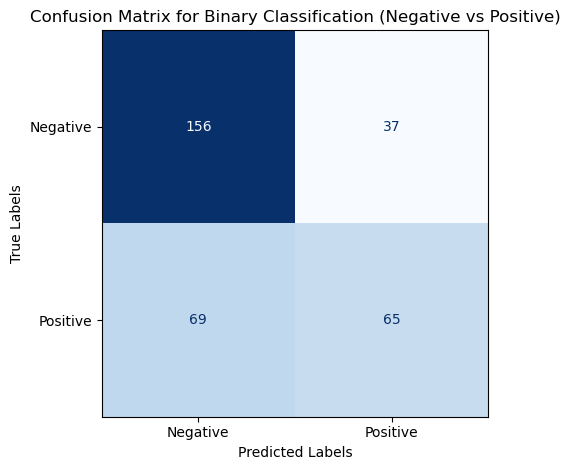

In [159]:
# Inverse transform predictions and true values to get the original scale
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Function to classify into 2 classes based on the sign
def classify_into_classes(y):
    if y < 0:
        return -1  # Negative values
    else:
        return 1  # Positive values

# Apply classification function to actual and predicted values
y_pred_classes = np.array([classify_into_classes(y) for y in y_pred_orig])
y_test_classes = np.array([classify_into_classes(y) for y in y_test_orig])

# Calculate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Calculate Precision, Recall, Accuracy, F1 Score for each class
P = precision_score(y_test_classes, y_pred_classes, average=None, labels=[-1, 1])
R = recall_score(y_test_classes, y_pred_classes, average=None, labels=[-1, 1])
Acc = accuracy_score(y_test_classes, y_pred_classes)
F1 = f1_score(y_test_classes, y_pred_classes, average=None, labels=[-1, 1])

# Print Confusion Matrix
print("Confusion Matrix:")
print(cm)

# Print classification metrics for each class
for class_label, precision, recall, f1 in zip([-1, 1], P, R, F1):
    print(f'Class {class_label}:')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    print(f'  F1 Score: {f1:.4f}')

# Print overall accuracy
print(f'Accuracy (Acc): {Acc:.4f}')

# Plot the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues', values_format='g', colorbar=False)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Binary Classification (Negative vs Positive)')
plt.tight_layout()
plt.show()


Confusion Matrix:
[[35 61  4  1]
 [11 49 31  1]
 [ 4 46 27  3]
 [ 0 19 22 13]]
Class -2:
  Precision: 0.7000
  Recall: 0.3465
  F1 Score: 0.4636
Class -1:
  Precision: 0.2800
  Recall: 0.5326
  F1 Score: 0.3670
Class 1:
  Precision: 0.3214
  Recall: 0.3375
  F1 Score: 0.3293
Class 2:
  Precision: 0.7222
  Recall: 0.2407
  F1 Score: 0.3611
Accuracy (Acc): 0.3792


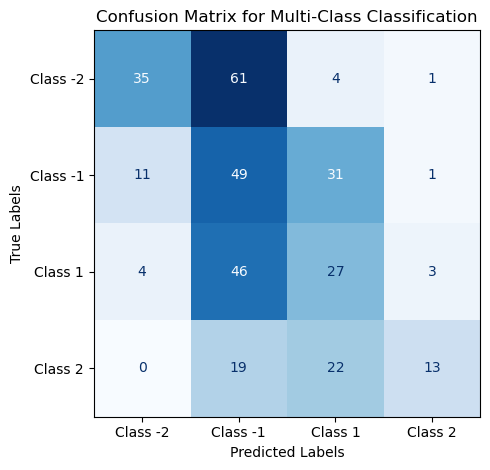

In [160]:
# Inverse transform predictions and true values to get the original scale
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Function to classify into 4 classes
def classify_into_classes(y):
    if y < 0:
        if y >= -250:
            return -1  # y in [-100, 0)
        else:
            return -2  # y < -100
    elif y < 250:
        return 1  # y in [0, 100)
    else:
        return 2  # y >= 100

# Apply classification function to actual and predicted values
y_pred_classes = np.array([classify_into_classes(y) for y in y_pred_orig])
y_test_classes = np.array([classify_into_classes(y) for y in y_test_orig])

# Calculate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Calculate Precision, Recall, Accuracy, F1 Score for each class
P = precision_score(y_test_classes, y_pred_classes, average=None, labels=[-2, -1, 1, 2])
R = recall_score(y_test_classes, y_pred_classes, average=None, labels=[-2, -1, 1, 2])
Acc = accuracy_score(y_test_classes, y_pred_classes)
F1 = f1_score(y_test_classes, y_pred_classes, average=None, labels=[-2, -1, 1, 2])

# Print Confusion Matrix
print("Confusion Matrix:")
print(cm)

# Print classification metrics for each class
for class_label, precision, recall, f1 in zip([-2, -1, 1, 2], P, R, F1):
    print(f'Class {class_label}:')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    print(f'  F1 Score: {f1:.4f}')

# Print overall accuracy
print(f'Accuracy (Acc): {Acc:.4f}')

# Plot the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class -2", "Class -1", "Class 1", "Class 2"])
disp.plot(cmap='Blues', values_format='g', colorbar=False)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Multi-Class Classification')
plt.tight_layout()
plt.show()

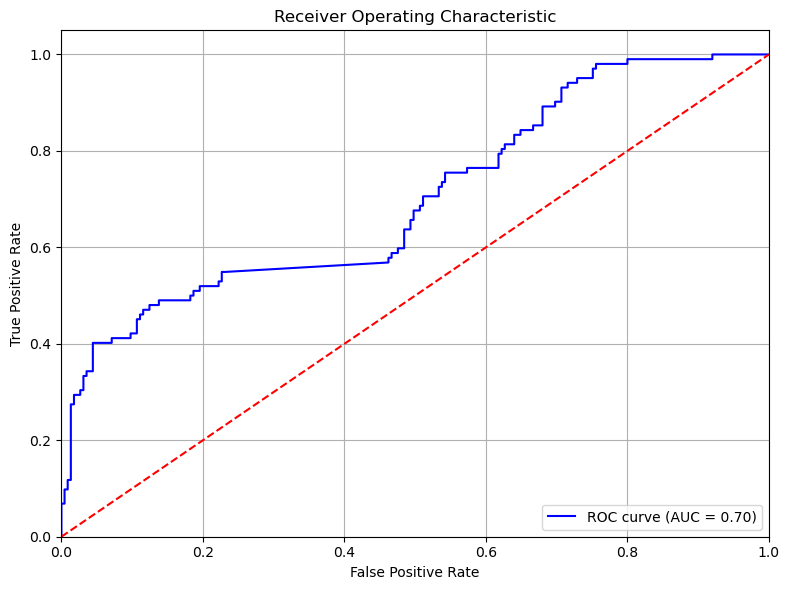

AUC: 0.70


In [161]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_orig)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

# Print AUC
print(f"AUC: {roc_auc:.2f}")

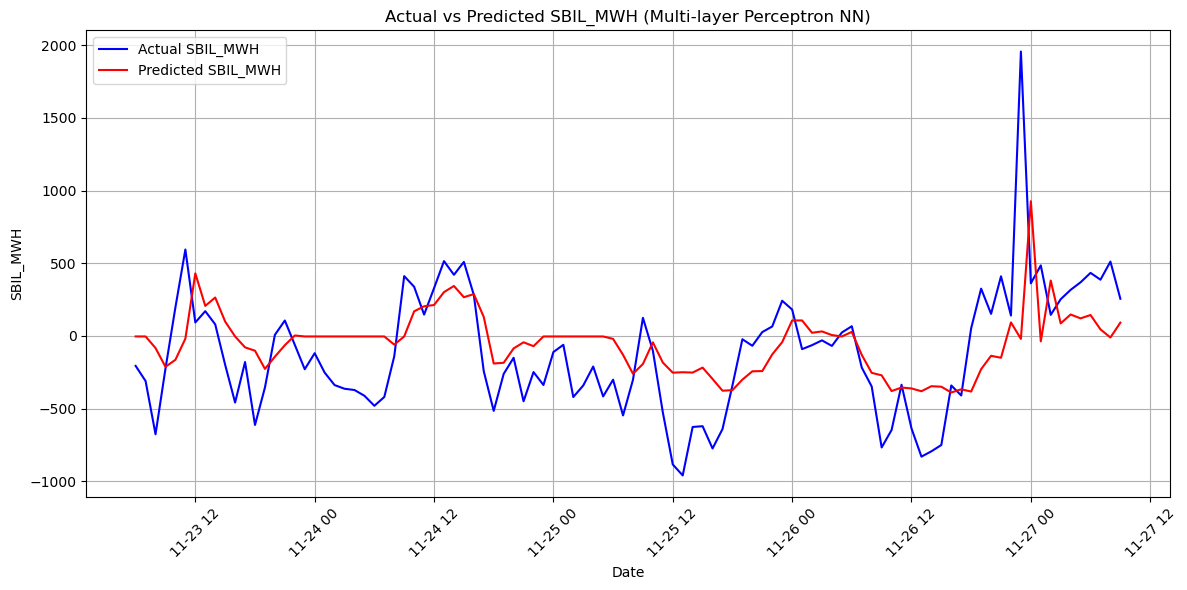

In [162]:
# Specify the number of most recent entries to plot
n = 100

# Inverse transform predictions and target for plotting (last n entries)
y_test_last_n = scaler_y.inverse_transform(y_test[-n:].reshape(-1, 1)).flatten()
y_pred_last_n = scaler_y.inverse_transform(y_pred[-n:].reshape(-1, 1)).flatten()

# Filter the rows where the target 'SBIL_MWH' is not NaN
valid_target_index = df_nord[~df_nord['SBIL_MWH'].isna()].index

# Get the last 'n' timestamps from the valid target index
dates_last_n = valid_target_index[-n:]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates_last_n, y_test_last_n, label='Actual SBIL_MWH', color='blue')
plt.plot(dates_last_n, y_pred_last_n, label='Predicted SBIL_MWH', color='red')
plt.title('Actual vs Predicted SBIL_MWH (Multi-layer Perceptron NN)')
plt.xlabel('Date')
plt.ylabel('SBIL_MWH')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

<h3> Let's predict the future </h3>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


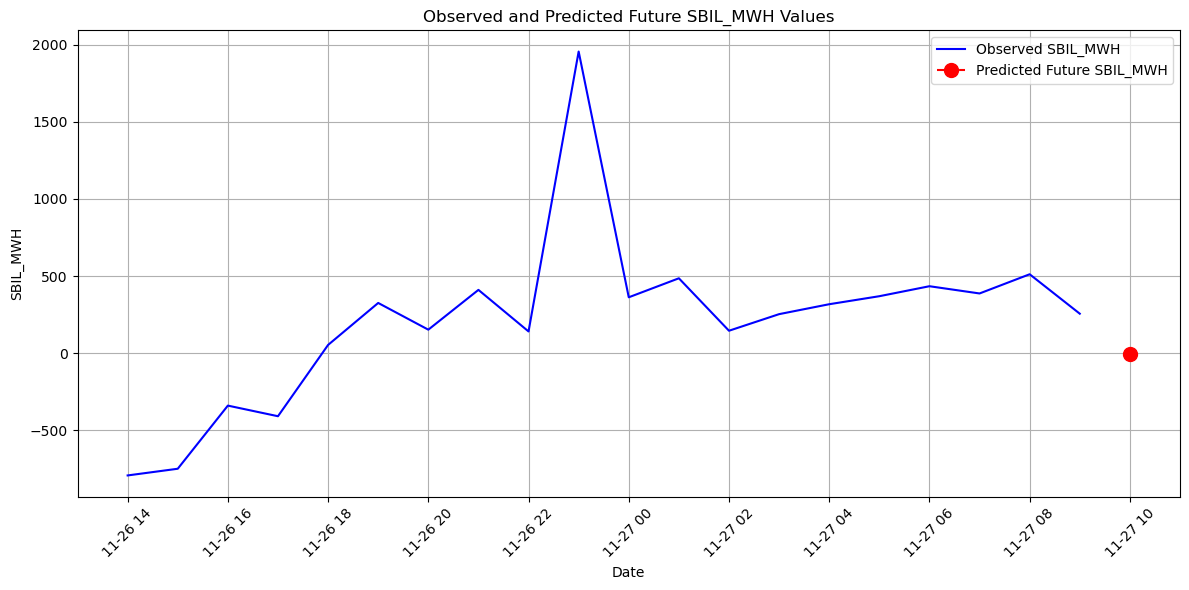

In [163]:
# Number of future steps you want to predict (set to 1 for the next step)
n_future_steps = 1

# Filter the rows where the target 'SBIL_MWH' is not NaN
valid_target_index = df_nord[~df_nord['SBIL_MWH'].isna()].index

# Get the last timestamp from the valid target index
last_timestamp = valid_target_index[-1]

# Get the most recent data from the test set to start the prediction
last_past = X_past_test[-1].reshape(1, -1)   # Last known past covariates
last_future = X_future_test[-1].reshape(1, -1)  # Last known future covariates
last_present = X_present_test[-1].reshape(1, -1)  # Last known present covariates

# Normalize the data for prediction
last_past_norm = scaler_X_past.transform(last_past)
last_future_norm = scaler_X_future.transform(last_future)
last_present_norm = scaler_X_present.transform(last_present)

# Combine the last known values as the input for prediction
last_input = np.concatenate([last_past_norm, last_future_norm, last_present_norm], axis=1)

# Predict the next time step (one value)
next_value = model1.predict(last_input)

# Inverse transform the predicted value to get it back to the original scale
next_value_orig = scaler_y.inverse_transform(next_value.reshape(-1, 1)).flatten()[0]

# Append the predicted value to the list (for future plotting)
predicted_values = [next_value_orig]

# Add one hour to the timestamp to predict the next time step
next_timestamp = last_timestamp + pd.Timedelta(hours=1)
future_dates = [next_timestamp]

# Create a DataFrame to store the predicted future value
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_SBIL_MWH': predicted_values
})

# Get the last `n` actual observations (from the test set) for plotting
n_last_obs = 20  # For example, plot the last 20 observed values
last_observed_df = pd.DataFrame({
    'Date': valid_target_index[-n_last_obs:],
    'Actual_SBIL_MWH': scaler_y.inverse_transform(y_test[-n_last_obs:].reshape(-1, 1)).flatten()
})

# Plot the last observed values and the predicted future value
plt.figure(figsize=(12, 6))

# Plot observed values
plt.plot(last_observed_df['Date'], last_observed_df['Actual_SBIL_MWH'], label='Observed SBIL_MWH', color='blue')

# Plot predicted value with a large point
plt.plot(future_df['Date'], future_df['Predicted_SBIL_MWH'], label='Predicted Future SBIL_MWH', color='red', linestyle='--', marker='o', markersize=10)

# Add labels and title
plt.title('Observed and Predicted Future SBIL_MWH Values')
plt.xlabel('Date')
plt.ylabel('SBIL_MWH')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()



In [164]:
future_df

,Date,Predicted_SBIL_MWH
0,2024-11-27 10:00:00,-3.299969


In [165]:
import os
# Assuming your existing DataFrame is stored in a CSV file (e.g., 'data.csv')
file_path = 'C:\imbalance_forecast\data\df_nord_h_future.csv'

# Step 1: Check if the file exists and is not empty
if os.path.exists(file_path) and os.stat(file_path).st_size > 0:
    # Read the existing DataFrame from the CSV file
    df_existing = pd.read_csv(file_path)
else:
    # If the file does not exist or is empty, create an empty DataFrame with the necessary columns
    df_existing = pd.DataFrame(columns=['Date', 'Predicted_SBIL_MWH'])

# Step 2: Ensure the columns exist, and if the file is empty, create them
if df_existing.empty:
    df_existing = pd.DataFrame(columns=['Date', 'Predicted_SBIL_MWH'])

# Step 3: Ensure the 'Date' column is in datetime format for proper comparison
df_existing['Date'] = pd.to_datetime(df_existing['Date'], errors='coerce')

# Step 4: Check if any existing data has the same 'Date' as in future_df
# Assuming future_df has only one new row to append
# Convert the 'Date' column in future_df to datetime if necessary
future_df['Date'] = pd.to_datetime(future_df['Date'], errors='coerce')

# Step 5: Handle duplicates by checking if the date already exists in df_existing
if future_df['Date'].iloc[0] in df_existing['Date'].values:
    # Replace the row with the same Date in df_existing
    df_existing.loc[df_existing['Date'] == future_df['Date'].iloc[0], 'Predicted_SBIL_MWH'] = future_df['Predicted_SBIL_MWH'].iloc[0]
else:
    # If the date does not exist, append the new row to df_existing
    df_existing = pd.concat([df_existing, future_df], ignore_index=True)

# Step 6: Save the updated DataFrame back to the CSV file
df_existing.to_csv(file_path, index=False)

print("Data successfully appended or updated in the file.")

Data successfully appended or updated in the file.


<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:3: SyntaxWarning: invalid escape sequence '\i'
C:\Users\samueledelia\AppData\Local\Temp\2\ipykernel_2112\66487769.py:3: SyntaxWarning: invalid escape sequence '\i'
  file_path = 'C:\imbalance_forecast\data\df_nord_h_future.csv'
